# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

The dataset collected is related to 17 campaigns that occurred between May 2008 and November 2010, 
corresponding to a total of 79354 contacts. During these phone campaigns, an attractive long-term deposit 
application, with good interest rates, was offered. For each contact, a large number of attributes was stored (e.g. see 
Table 2) and if there was a success (the target variable). For the whole database considered, there were 6499
successes (8% success rate).

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [435]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.pipeline import Pipeline
from scipy.optimize import minimize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.metrics import  classification_report, confusion_matrix

import time
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [436]:
# Read the CSV file  
file_path = r'C:\Users\willi\OneDrive\AI ML\bank-additional-full.csv'

df = pd.read_csv(file_path)


df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [437]:
# rename some features
df.rename(columns={'campaign': 'current_contacts', 'pdays': 'days_after_prevcamp', 'poutcome': 'precamp_output', 'emp.var.rate': 'employment_var_rate', 'cons.price.idx': 'consumer_price_I', 'cons.conf.idx': 'consumer_confidence_I', 'euribor3m': 'euribor_3monthrate', 'nr.employed': 'Num_employees', 'previous': 'previous_contact'}, inplace=True)

In [438]:
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,current_contacts,days_after_prevcamp,previous_contact,precamp_output,employment_var_rate,consumer_price_I,consumer_confidence_I,euribor_3monthrate,Num_employees,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [439]:
# Evaluate attribute and null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   age                    41188 non-null  int64  
 1   job                    41188 non-null  object 
 2   marital                41188 non-null  object 
 3   education              41188 non-null  object 
 4   default                41188 non-null  object 
 5   housing                41188 non-null  object 
 6   loan                   41188 non-null  object 
 7   contact                41188 non-null  object 
 8   month                  41188 non-null  object 
 9   day_of_week            41188 non-null  object 
 10  duration               41188 non-null  int64  
 11  current_contacts       41188 non-null  int64  
 12  days_after_prevcamp    41188 non-null  int64  
 13  previous_contact       41188 non-null  int64  
 14  precamp_output         41188 non-null  object 
 15  em

# No null value is observed

In [440]:
#The following features need transformation as they are data object:
object_columns = df.select_dtypes(include=['object']).columns
print(object_columns)


Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'precamp_output', 'y'],
      dtype='object')


### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

The goal is to compare the performance of the classifiers: K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines. 
    This is for build a model capable to accurate predict the results of a campaign. This will help to assign resources to those areas that increase the  possibility of a person subscribe to the deposit

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features (columns 1 - 7), prepare the features and target column for modeling with appropriate encoding and transformations.

In [442]:
columns_list = df.columns.tolist()
columns_list

['age',
 'job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'duration',
 'current_contacts',
 'days_after_prevcamp',
 'previous_contact',
 'precamp_output',
 'employment_var_rate',
 'consumer_price_I',
 'consumer_confidence_I',
 'euribor_3monthrate',
 'Num_employees',
 'y']

In [443]:
# this is for last question 
df1=df
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,current_contacts,days_after_prevcamp,previous_contact,precamp_output,employment_var_rate,consumer_price_I,consumer_confidence_I,euribor_3monthrate,Num_employees,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


In [444]:
# Once Hot encoder to change the object data 
bank_transformer = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['age']), 
        ('cat', OneHotEncoder(drop='if_binary', sparse=False, handle_unknown='ignore'), ['job', 'marital', 'education', 'default', 'housing', 'loan']),
   ],
    remainder='passthrough')
# this is to select the columns for the df as only the first seven features and the other numeric features
df = df[['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'duration', 'current_contacts', 'days_after_prevcamp', 'previous_contact', 'employment_var_rate', 'consumer_price_I',
 'consumer_confidence_I', 'euribor_3monthrate', 'Num_employees', 'y']]

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [445]:
# assigning the data to X and converting to numeric the target.
X = df.drop(['y'], axis = 1)
Y = df['y'].map({'no': 0, 'yes': 1})
df

,age,job,marital,education,default,housing,loan,duration,current_contacts,days_after_prevcamp,previous_contact,employment_var_rate,consumer_price_I,consumer_confidence_I,euribor_3monthrate,Num_employees,y
0,56,housemaid,married,basic.4y,no,no,no,261,1,999,0,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,149,1,999,0,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,226,1,999,0,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,151,1,999,0,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,307,1,999,0,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,334,1,999,0,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,383,1,999,0,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,189,2,999,0,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,442,1,999,0,-1.1,94.767,-50.8,1.028,4963.6,yes


In [446]:
# Prepare the data for train and test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state = 42)

In [447]:

y_train

12556    0
35451    0
30592    0
17914    0
3315     0
        ..
6265     0
11284    0
38158    1
860      0
15795    0
Name: y, Length: 32950, dtype: int64

In [448]:
X_train

,age,job,marital,education,default,housing,loan,duration,current_contacts,days_after_prevcamp,previous_contact,employment_var_rate,consumer_price_I,consumer_confidence_I,euribor_3monthrate,Num_employees
12556,40,blue-collar,married,basic.9y,unknown,yes,no,94,2,999,0,1.4,93.918,-42.7,4.960,5228.1
35451,31,admin.,married,university.degree,no,no,no,116,4,999,0,-1.8,92.893,-46.2,1.244,5099.1
30592,59,retired,married,basic.4y,no,no,no,13,6,999,1,-1.8,92.893,-46.2,1.354,5099.1
17914,43,housemaid,divorced,basic.9y,no,yes,no,94,5,999,0,1.4,93.918,-42.7,4.961,5228.1
3315,39,admin.,single,high.school,unknown,no,no,344,2,999,0,1.1,93.994,-36.4,4.860,5191.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6265,58,retired,married,professional.course,unknown,no,no,427,2,999,0,1.1,93.994,-36.4,4.857,5191.0
11284,37,management,married,university.degree,no,no,no,288,1,999,0,1.4,94.465,-41.8,4.961,5228.1
38158,35,admin.,married,high.school,no,yes,no,194,1,4,1,-3.4,92.431,-26.9,0.754,5017.5
860,40,management,married,university.degree,no,yes,no,295,2,999,0,1.1,93.994,-36.4,4.856,5191.0


### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [449]:

# Step 1: Determine the Majority Class
majority_class = y_train.value_counts().idxmax()

# Step 2: Create a Dummy Classifier Predicting the Majority Class
baseline_model = DummyClassifier(strategy='most_frequent', random_state=42)
baseline_model.fit(X_train, y_train)

# Step 3: Evaluate the Baseline Model
baseline_predictions = baseline_model.predict(X_test)

# Calculate Accuracy
baseline_accuracy = accuracy_score(y_test, baseline_predictions)

# Generate a Classification Report
classification_rep = classification_report(y_test, baseline_predictions)

# Generate a Confusion Matrix
confusion_mtx = confusion_matrix(y_test, baseline_predictions)

# Print Results
print(f"Majority Class: {majority_class}")
print(f"Baseline Accuracy: {baseline_accuracy:.2f}")
print("Classification Report:\n", classification_rep)
print("Confusion Matrix:\n", confusion_mtx)

Majority Class: 0
Baseline Accuracy: 0.89
Classification Report:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94      7303
           1       0.00      0.00      0.00       935

    accuracy                           0.89      8238
   macro avg       0.44      0.50      0.47      8238
weighted avg       0.79      0.89      0.83      8238

Confusion Matrix:
 [[7303    0]
 [ 935    0]]


C:\Users\willi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\willi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\willi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Baseline accuracy using the confusion matrix: 89%

### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [468]:
# logstic Regression Fit
lgr_pipe = Pipeline([('transformer',bank_transformer),                
                    ('lgr', LogisticRegression())])
lgr_pipe.fit(X_train, y_train)


C:\Users\willi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['age']),
                                                 ('cat',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse=False),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan'])])),
                ('lgr', LogisticRegression())])

### Problem 9: Score the Model

What is the accuracy of your model?

In [471]:
pipe_acc = lgr_pipe.score(X_test, y_test)

print(pipe_acc)
# The accuracy of the model is better than the baseline

0.9110220927409566


### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [453]:

# Initialize models

lgr_pipe = Pipeline([('transformer',bank_transformer),                
                    ('lgr', LogisticRegression())])
knn_pipe = Pipeline([('transformer',bank_transformer),                
                    ('knn',  KNeighborsClassifier())])
dt_pipe =  Pipeline([('transformer',bank_transformer),                
                    ('dt',  DecisionTreeClassifier())])
svm_pipe = Pipeline([('transformer',bank_transformer),                
                    ('svm',  SVC())])

# Create a DataFrame to store the results
results_df = pd.DataFrame(columns=['Model', 'Train Time', 'Train Accuracy', 'Test Accuracy'])

# Define a function to fit and evaluate a model
def fit_and_evaluate_model(model, model_name, X_train, y_train, X_test, y_test):
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    
    train_accuracy = model.score(X_train, y_train)
    test_accuracy = model.score(X_test, y_test)
    
    return [model_name, train_time, train_accuracy, test_accuracy]

# Fit and evaluate each model and store the results in the DataFrame
models = [
    (lgr_pipe, 'Logistic Regression'),
    (knn_pipe, 'K-Nearest Neighbors'),
    (dt_pipe, 'Decision Tree'),
    (svm_pipe, 'Support Vector Machine')
]

for model, model_name in models:
    result = fit_and_evaluate_model(model, model_name, X_train, y_train, X_test, y_test)
    results_df = results_df.append(pd.Series(result, index=results_df.columns), ignore_index=True)

# Display the results
print(results_df)

C:\Users\willi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


                    Model  Train Time  Train Accuracy  Test Accuracy
0     Logistic Regression    0.444202        0.908832       0.911022
1     K-Nearest Neighbors    0.074226        0.931047       0.901918
2           Decision Tree    0.397830        1.000000       0.884924
3  Support Vector Machine   24.396662        0.898483       0.894513


Based on accuracy for all models the Logistic Regression performs better as the Test accuracy is the higher. 
Decision Tree seems to overfit with 100% on train accuracy but below 90 on test accruacy. 
Support Vector performs the same on Train and Test accuracy while K-nearest Neighbors seems to overfit with the Train accuracy significant higher than Test Accuracy.
Support Vector Machine Train time is significant higher than the other models.

### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

In [ ]:
# Convert 'y' column to binary (0 or 1) for rate calculation
df['y'] = df['y'].map({'yes': 1, 'no': 0})

# Assess each Feature

Text(0.5, 1.0, 'age by Subscription decision ')

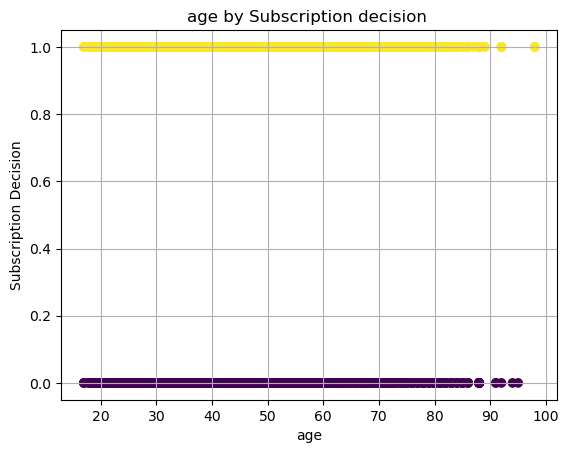

In [314]:
# Subcription decision vs Age
X1 = df[['age']]
plt.scatter(X1, Y , c = Y)
plt.grid()
plt.xlabel('age')
plt.ylabel('Subscription Decision')
plt.title('age by Subscription decision ')


# This chart does not provide enough information to include or exclude this feature.

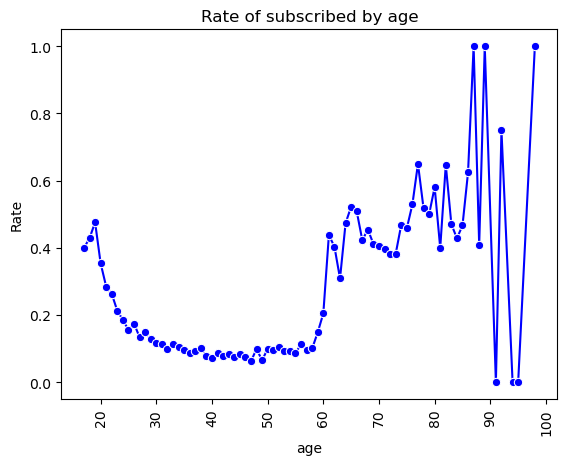

In [394]:
# Aggregate the data for Rate calculation
agg_data = df.groupby('age').agg({'age': 'count', 'y': 'sum'}).rename(columns={'age': 'Count_age', 'y': 'Subscribed'})
# Calculate the rate by dividing the sum by the count
agg_data['Rate'] = agg_data['Subscribed'] / agg_data['Count_age']

# Create a line chart
sns.lineplot(data=agg_data.reset_index(), x='age', y='Rate', marker='o', color='b')

plt.title('Rate of subscribed by age')
plt.ylabel('Rate')
plt.xlabel('age')
plt.xticks(rotation=90)
plt.show()


# The subscription rate varies over different ages, this feature must be kept

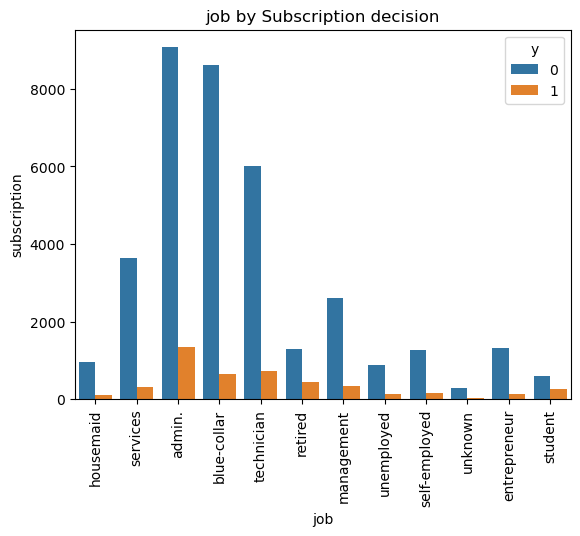

In [358]:
# Bar chart Subcription decision vs job count the yes and no 
X1 = df['job']
sns.countplot(data=df, x=X1, hue=Y)
plt.title('job by Subscription decision')
plt.ylabel('subscription')
plt.xticks(rotation=90)
plt.show()


# This chart does not provide enough information about the relevance of job feature. 

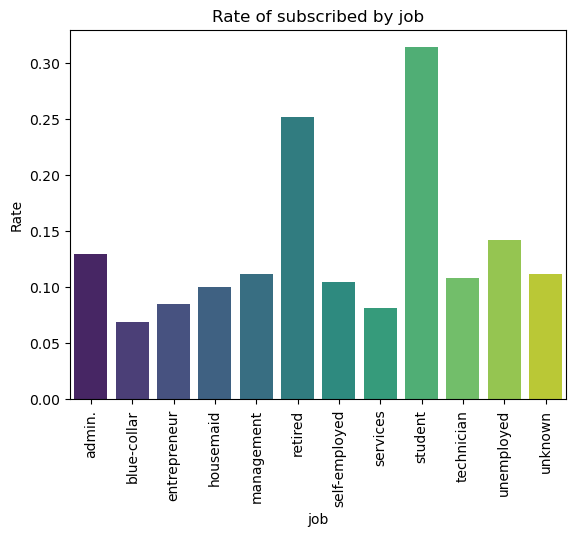

In [393]:
# Group by and calculate the count and sum of 'y'
agg_data = df.groupby('job').agg({'job': 'count', 'y': 'sum'}).rename(columns={'job': 'Count_job', 'y': 'Subscribed'})

# Calculate the rate by dividing the sum by the count
agg_data['Rate'] = agg_data['Subscribed'] / agg_data['Count_job']

# Create a rate chart
sns.barplot(data=agg_data.reset_index(), x='job', y='Rate', palette='viridis')

plt.title('Rate of subscribed by job')
plt.ylabel('Rate')
plt.xlabel('job')
plt.xticks(rotation=90)
plt.show()


# Subcription rate varies over different job categories, this feature must be kept.

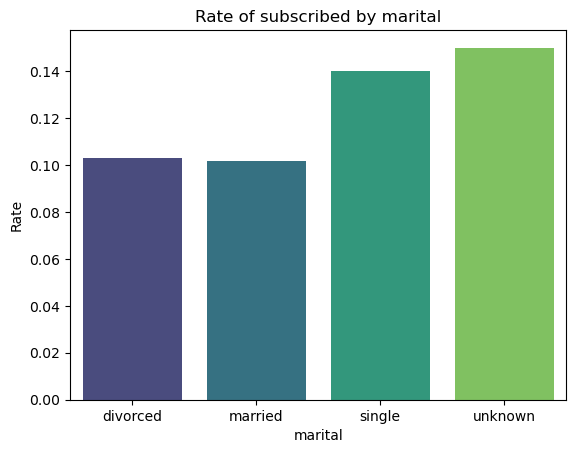

In [389]:
# Group by and calculate the count and sum of 'y'
agg_data = df.groupby('marital').agg({'marital': 'count', 'y': 'sum'}).rename(columns={'marital': 'Count_marital', 'y': 'Subscribed'})

# Calculate the rate by dividing the sum by the count
agg_data['Rate'] = agg_data['Subscribed'] / agg_data['Count_marital']

# Create a rate chart
sns.barplot(data=agg_data.reset_index(), x='marital', y='Rate', palette='viridis')

plt.title('Rate of subscribed by marital')
plt.ylabel('Rate')
plt.xlabel('marital')
plt.show()


# The subscription rate does not change over different marrital status also, the top rate is under unknown marital status, this feature can be removed.

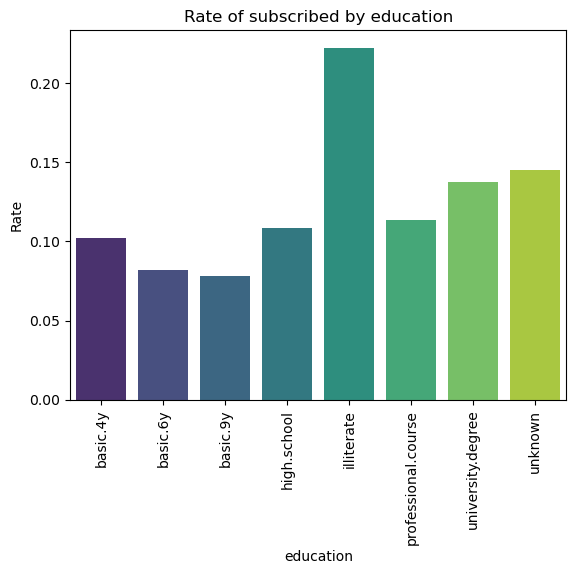

In [391]:
# Group by and calculate the count and sum of 'y'
agg_data = df.groupby('education').agg({'education': 'count', 'y': 'sum'}).rename(columns={'education': 'Count_education', 'y': 'Subscribed'})

# Calculate the rate by dividing the sum by the count
agg_data['Rate'] = agg_data['Subscribed'] / agg_data['Count_education']

# Create a rate chart
sns.barplot(data=agg_data.reset_index(), x='education', y='Rate', palette='viridis')

plt.title('Rate of subscribed by education')
plt.ylabel('Rate')
plt.xlabel('education')
plt.xticks(rotation=90)
plt.show()


# Subscription rate change over different education categories, this feature  can be kept.

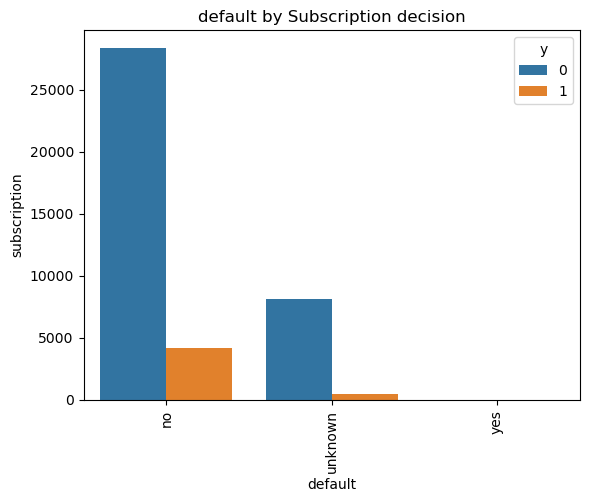

In [355]:
# Bar chart Subcription decision vs defaul count the yes and no 
X1 = df['default']
sns.countplot(data=df, x=X1, hue=Y)
plt.title('default by Subscription decision')
plt.ylabel('subscription')
plt.xticks(rotation=90)
plt.show()

# No Subscription is observed for default yes, this feature  can be kept.

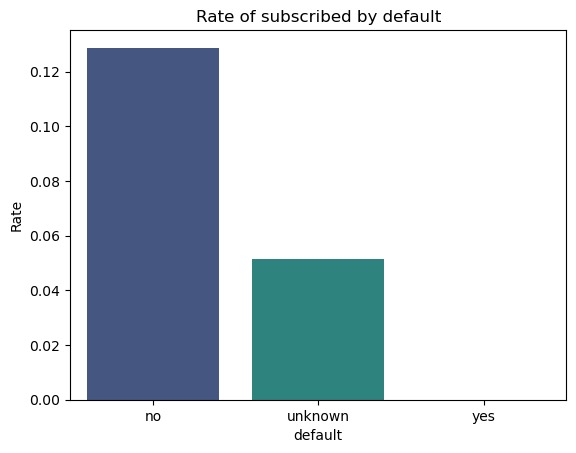

In [388]:
# Group by and calculate the count and sum of 'y'
agg_data = df.groupby('default').agg({'default': 'count', 'y': 'sum'}).rename(columns={'default': 'Count_default', 'y': 'Subscribed'})

# Calculate the rate by dividing the sum by the count
agg_data['Rate'] = agg_data['Subscribed'] / agg_data['Count_default']

# Create a rate chart
sns.barplot(data=agg_data.reset_index(), x='default', y='Rate', palette='viridis')

plt.title('Rate of subscribed by default')
plt.ylabel('Rate')
plt.xlabel('default')
plt.show()


# zero Subscription rate is observed for default yes, this feature must be kept.

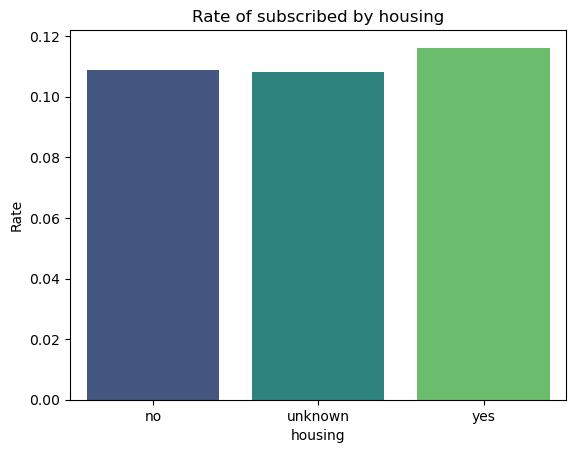

In [387]:
# Group by and calculate the count and sum of 'y'
agg_data = df.groupby('housing').agg({'housing': 'count', 'y': 'sum'}).rename(columns={'housing': 'Count_housing', 'y': 'Subscribed'})

# Calculate the rate by dividing the sum by the count
agg_data['Rate'] = agg_data['Subscribed'] / agg_data['Count_housing']

# Create a rate chart
sns.barplot(data=agg_data.reset_index(), x='housing', y='Rate', palette='viridis')

plt.title('Rate of subscribed by housing')
plt.ylabel('Rate')
plt.xlabel('housing')
plt.show()



# subscription rate is very similar among the different housing categories, this feature can be removed.

C:\Users\willi\AppData\Local\Temp\ipykernel_5528\1565510645.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['y'] = df['y'].map({'yes': 1, 'no': 0})


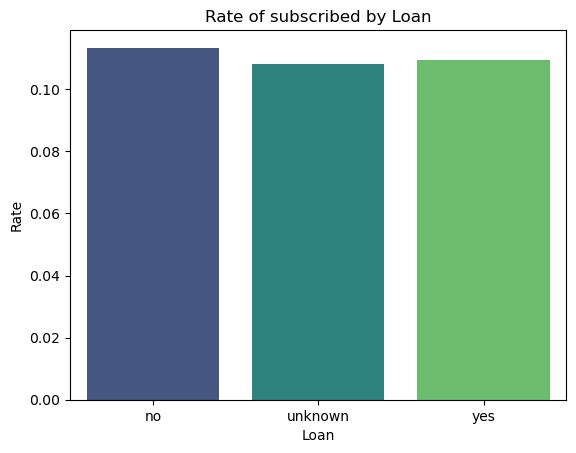

In [382]:


# Group by 'loan' and calculate the count and sum of 'y'
agg_data = df.groupby('loan').agg({'loan': 'count', 'y': 'sum'}).rename(columns={'loan': 'Count_loan', 'y': 'Subscribed'})

# Calculate the rate by dividing the sum by the count
agg_data['Rate'] = agg_data['Subscribed'] / agg_data['Count_loan']

# Create a rate chart
sns.barplot(data=agg_data.reset_index(), x='loan', y='Rate', palette='viridis')

plt.title('Rate of subscribed by Loan')
plt.ylabel('Rate')
plt.xlabel('Loan')
plt.show()



# subcription rate is very similar among the different loan categories, this feature can be removed.

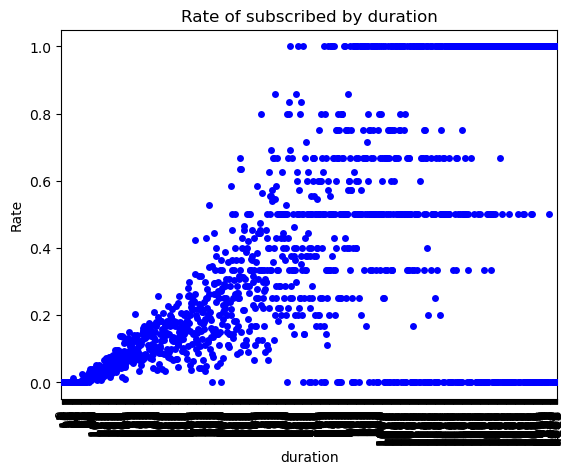

In [397]:
# Group by  and calculate the count and sum of 'y'
agg_data = df.groupby('duration').agg({'duration': 'count', 'y': 'sum'}).rename(columns={'duration': 'Count_duration', 'y': 'Subscribed'})

# Calculate the rate by dividing the sum by the count
agg_data['Rate'] = agg_data['Subscribed'] / agg_data['Count_duration']

# Create a line chart
#sns.lineplot(data=agg_data.reset_index(), x='duration', y='Rate', marker='o', color='b')
sns.stripplot(data=agg_data.reset_index(), x='duration', y='Rate', jitter=True, color='b', size=5)

plt.title('Rate of subscribed by duration')
plt.ylabel('Rate')
plt.xlabel('duration')
plt.xticks(rotation=90)
plt.show()


# The scatter plot shows an increasing trend on the subscription rate as duration increase, this feature must be kept

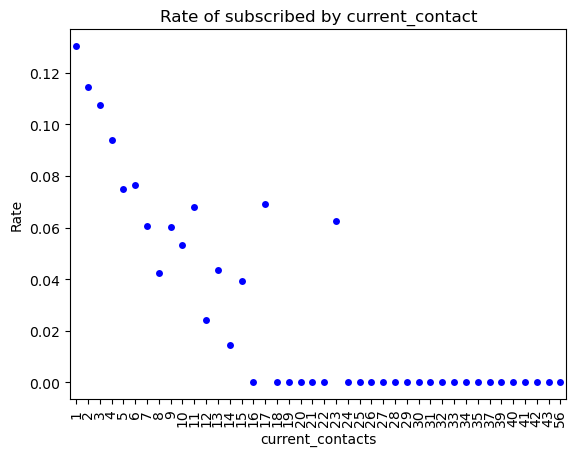

In [407]:
# Group by  and calculate the count and sum of 'y'
agg_data = df.groupby('current_contacts').agg({'current_contacts': 'count', 'y': 'sum'}).rename(columns={'current_contacts': 'Count_current_contacts', 'y': 'Subscribed'})

# Calculate the rate by dividing the sum by the count
agg_data['Rate'] = agg_data['Subscribed'] / agg_data['Count_current_contacts']

# Create scatter plot
sns.stripplot(data=agg_data.reset_index(), x='current_contacts', y='Rate', jitter=True, color='b', size=5)

plt.title('Rate of subscribed by current_contact')
plt.ylabel('Rate')
plt.xlabel('current_contacts')
plt.xticks(rotation=90)
plt.show()
# as the current contact decrease the subcription rate also decrease, this feature must be kept

# The scatter plot shows a decreasing trend on the subscription rate as current_contact increase, this feature must be kept

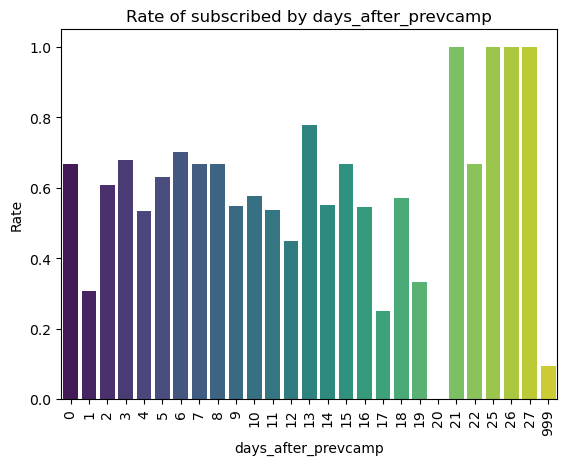

In [385]:
# Group by and calculate the count and sum of 'y'
agg_data = df.groupby('days_after_prevcamp').agg({'days_after_prevcamp': 'count', 'y': 'sum'}).rename(columns={'days_after_prevcamp': 'Count_days_after_prevcamp', 'y': 'Subscribed'})

# Calculate the rate by dividing the sum by the count
agg_data['Rate'] = agg_data['Subscribed'] / agg_data['Count_days_after_prevcamp']

# Create a rate chart
sns.barplot(data=agg_data.reset_index(), x='days_after_prevcamp', y='Rate', palette='viridis')

plt.title('Rate of subscribed by days_after_prevcamp')
plt.ylabel('Rate')
plt.xlabel('days_after_prevcamp')
plt.xticks(rotation=90)
plt.show()

# Subscription rate change over days_after_prevcamp, this feature must be kept.

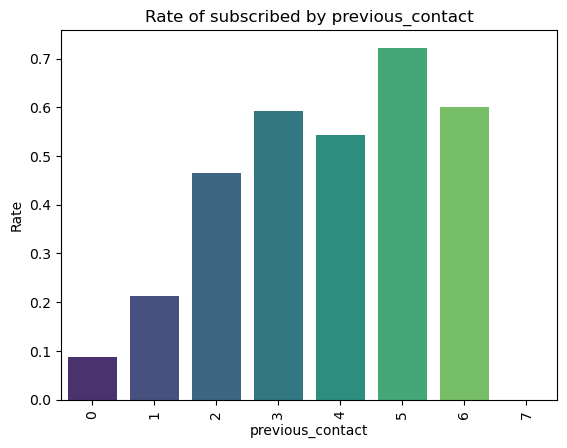

In [386]:
# Group by and calculate the count and sum of 'y'
agg_data = df.groupby('previous_contact').agg({'previous_contact': 'count', 'y': 'sum'}).rename(columns={'previous_contact': 'Count_previous_contact', 'y': 'Subscribed'})

# Calculate the rate by dividing the sum by the count
agg_data['Rate'] = agg_data['Subscribed'] / agg_data['Count_previous_contact']

# Create a rate chart
sns.barplot(data=agg_data.reset_index(), x='previous_contact', y='Rate', palette='viridis')

plt.title('Rate of subscribed by previous_contact')
plt.ylabel('Rate')
plt.xlabel('previous_contact')
plt.xticks(rotation=90)
plt.show()

# Subscription rate change as the previous contact increase, this feature must be kept

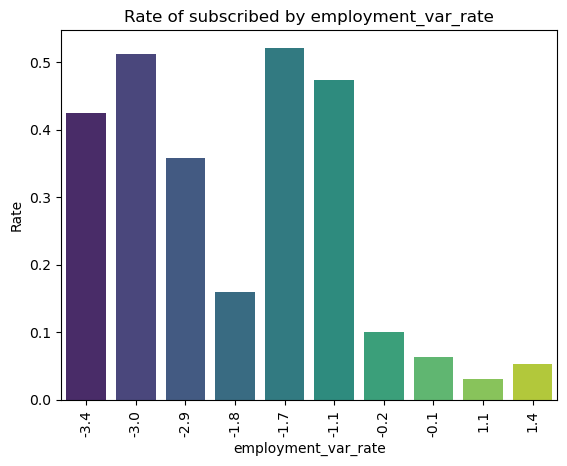

In [406]:
# Group by and calculate the count and sum of 'y'
agg_data = df.groupby('employment_var_rate').agg({'employment_var_rate': 'count', 'y': 'sum'}).rename(columns={'employment_var_rate': 'Count_employment_var_rate', 'y': 'Subscribed'})

# Calculate the rate by dividing the sum by the count
agg_data['Rate'] = agg_data['Subscribed'] / agg_data['Count_employment_var_rate']

# Create a rate chart
sns.barplot(data=agg_data.reset_index(), x='employment_var_rate', y='Rate', palette='viridis')

plt.title('Rate of subscribed by employment_var_rate')
plt.ylabel('Rate')
plt.xlabel('employment_var_rate')
plt.xticks(rotation=90)
plt.show()

# Subscription rate change as the employment var rate change, this feature must be kept

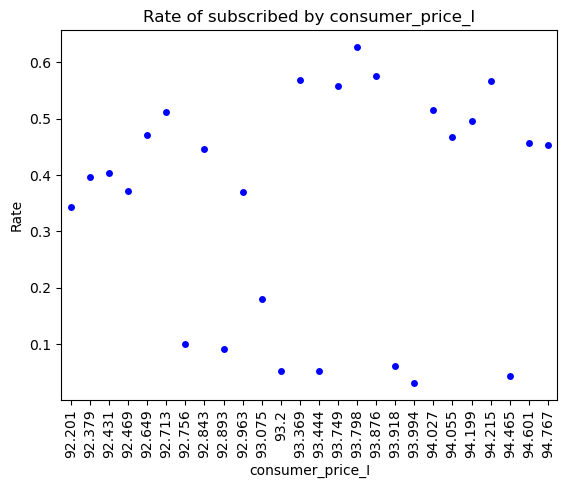

In [402]:
# Group by and calculate the count and sum of 'y'
agg_data = df.groupby('consumer_price_I').agg({'consumer_price_I': 'count', 'y': 'sum'}).rename(columns={'consumer_price_I': 'Count_consumer_price_I', 'y': 'Subscribed'})

# Calculate the rate by dividing the sum by the count
agg_data['Rate'] = agg_data['Subscribed'] / agg_data['Count_consumer_price_I']

# Create scatter plot
sns.stripplot(data=agg_data.reset_index(), x='consumer_price_I', y='Rate', jitter=True, color='b', size=5)

plt.title('Rate of subscribed by consumer_price_I')
plt.ylabel('Rate')
plt.xlabel('consumer_price_I')
plt.xticks(rotation=90)
plt.show()

# Subscription Rate change as consumer_price_I change, this feature must be kept. 

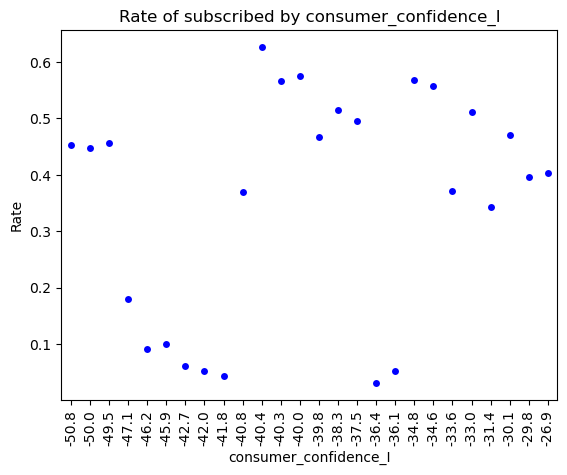

In [405]:
# Group by and calculate the count and sum of 'y'
agg_data = df.groupby('consumer_confidence_I').agg({'consumer_confidence_I': 'count', 'y': 'sum'}).rename(columns={'consumer_confidence_I': 'Count_consumer_confidence_I', 'y': 'Subscribed'})

# Calculate the rate by dividing the sum by the count
agg_data['Rate'] = agg_data['Subscribed'] / agg_data['Count_consumer_confidence_I']

# Create scatter plot
sns.stripplot(data=agg_data.reset_index(), x='consumer_confidence_I', y='Rate', jitter=True, color='b', size=5)

plt.title('Rate of subscribed by consumer_confidence_I')
plt.ylabel('Rate')
plt.xlabel('consumer_confidence_I')
plt.xticks(rotation=90)
plt.show()

# Subscription Rate change as consumer_confidence_I change, this feature must be kept

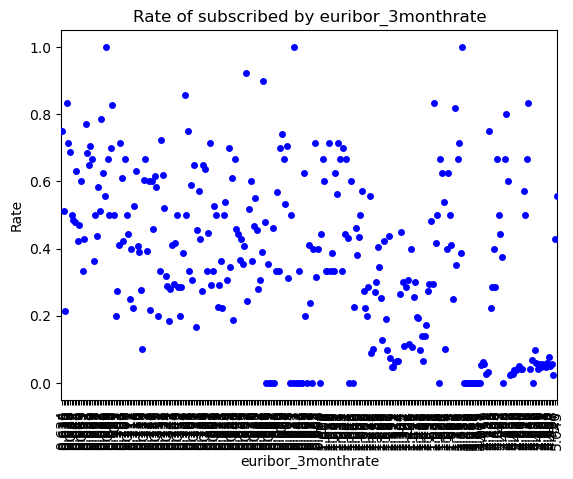

In [403]:
# Group by and calculate the count and sum of 'y'
agg_data = df.groupby('euribor_3monthrate').agg({'euribor_3monthrate': 'count', 'y': 'sum'}).rename(columns={'euribor_3monthrate': 'Count_euribor_3monthrate', 'y': 'Subscribed'})

# Calculate the rate by dividing the sum by the count
agg_data['Rate'] = agg_data['Subscribed'] / agg_data['Count_euribor_3monthrate']

# Create scatter plot
sns.stripplot(data=agg_data.reset_index(), x='euribor_3monthrate', y='Rate', jitter=True, color='b', size=5)

plt.title('Rate of subscribed by euribor_3monthrate')
plt.ylabel('Rate')
plt.xlabel('euribor_3monthrate')
plt.xticks(rotation=90)
plt.show()

# subcription rate is very similar among the different categories within euribor_3monthrate, this feature can be removed.

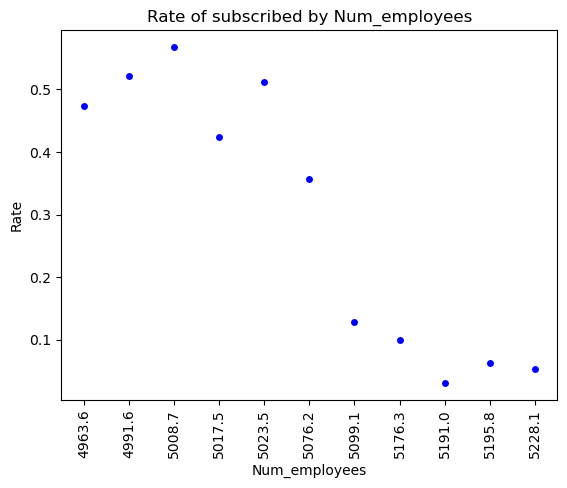

In [401]:
# Group by and calculate the count and sum of 'y'
agg_data = df.groupby('Num_employees').agg({'Num_employees': 'count', 'y': 'sum'}).rename(columns={'Num_employees': 'Count_Num_employees', 'y': 'Subscribed'})

# Calculate the rate by dividing the sum by the count
agg_data['Rate'] = agg_data['Subscribed'] / agg_data['Count_Num_employees']

# Create scatter plot
sns.stripplot(data=agg_data.reset_index(), x='Num_employees', y='Rate', jitter=True, color='b', size=5)

plt.title('Rate of subscribed by Num_employees')
plt.ylabel('Rate')
plt.xlabel('Num_employees')
plt.xticks(rotation=90)
plt.show()

# The scatter plot shows a decreasing trend on the subscription rate as Num_employees increase, this feature must be kept

In [456]:
# To assess coefficient
# Fit the pipeline to your training data
logreg = lgr_pipe.fit(X_train, y_train)

# Access coefficients from the Logistic Regression estimator inside the pipeline
coefficients = logreg.named_steps['lgr'].coef_[0].tolist()

# Add a coefficient for the intercept term
intercept = logreg.named_steps['lgr'].intercept_[0]
coefficients.insert(0, intercept)

# Create a list of feature names (including intercept)
feature_names = ['Intercept'] + X.columns.tolist()

# Create a list of tuples containing feature names and their coefficients
coef_names = list(zip(feature_names, coefficients))

# Display the list of coefficient names

coef_df = pd.DataFrame(coef_names)
print(coef_df)

                        0         1
0               Intercept  0.003195
1                     age  0.026592
2                     job  0.041922
3                 marital -0.087467
4               education -0.006181
5                 default -0.002031
6                 housing  0.001936
7                    loan  0.034326
8                duration -0.006173
9        current_contacts -0.025451
10    days_after_prevcamp  0.021495
11       previous_contact  0.025988
12    employment_var_rate  0.006218
13       consumer_price_I -0.001388
14  consumer_confidence_I  0.001070
15     euribor_3monthrate -0.045323
16          Num_employees  0.048027


C:\Users\willi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Recall (Sensitivity or True Positive Rate): Recall measures the proportion of true positive predictions out of all actual positive instances. It focuses on how well the classifier captures all positive instances. For the purpose of increase the prediction of a yes on the target, recall is a better metric for this problem.

# KNN GridSearch

In [474]:


# Define the parameter grid for accuracy optimization
params_accuracy = {'knn__n_neighbors': list(range(1, 50, 2))}

# Define the parameter grid for recall optimization
params_recall = {'knn__n_neighbors': list(range(1, 50, 2))}

# Grid search for accuracy optimization
grid_accuracy = GridSearchCV(knn_pipe, param_grid=params_accuracy).fit(X_train, y_train)
best_params_accuracy = grid_accuracy.best_params_

# Grid search for recall optimization
grid_recall = GridSearchCV(knn_pipe, param_grid=params_recall, scoring='recall').fit(X_train, y_train)
best_params_recall = grid_recall.best_params_

# Fit models with the best parameters
best_knn_accuracy = grid_accuracy.best_estimator_
best_knn_recall = grid_recall.best_estimator_

# Evaluate models on the test data
y_test_accuracy = best_knn_accuracy.predict(X_test)
y_test_recall = best_knn_recall.predict(X_test)

accuracy = accuracy_score(y_test, y_test_accuracy)
recall = recall_score(y_test, y_test_recall)

print(f'Best parameters for accuracy: {best_params_accuracy}')
print(f'Best parameters for recall: {best_params_recall}')
print(f'Accuracy on test data: {accuracy:.2f}')
print(f'Recall on test data: {recall:.2f}')

Best parameters for accuracy: {'knn__n_neighbors': 35}
Best parameters for recall: {'knn__n_neighbors': 19}
Accuracy on test data: 0.91
Recall on test data: 0.51


# Decision Tree GridSearch

In [473]:
# Define the parameter grid for accuracy optimization
params_accuracy = {
    'dt__min_impurity_decrease': [0.01, 0.02, 0.03, 0.05],
    'dt__max_depth': [2, 5, 10],
    'dt__min_samples_split': [0.1, 0.2, 0.05]
}

# Define the parameter grid for recall optimization
params_recall = {
    'dt__min_impurity_decrease': [0.01, 0.02, 0.03, 0.05],
    'dt__max_depth': [2, 5, 10],
    'dt__min_samples_split': [0.1, 0.2, 0.05]
}

# Grid search for accuracy optimization
grid_accuracy = GridSearchCV(dt_pipe, param_grid=params_accuracy).fit(X_train, y_train)
best_params_accuracy = grid_accuracy.best_params_

# Grid search for recall optimization
grid_recall = GridSearchCV(dt_pipe, param_grid=params_recall, scoring='recall').fit(X_train, y_train)
best_params_recall = grid_recall.best_params_

# Fit models with the best parameters
best_dt_accuracy = grid_accuracy.best_estimator_
best_dt_recall = grid_recall.best_estimator_

# Evaluate models on the test data
y_test_accuracy = best_dt_accuracy.predict(X_test)
y_test_recall = best_dt_recall.predict(X_test)

accuracy = accuracy_score(y_test, y_test_accuracy)
recall = recall_score(y_test, y_test_recall)

print(f'Best parameters for accuracy: {best_params_accuracy}')
print(f'Best parameters for recall: {best_params_recall}')
print(f'Accuracy on test data: {accuracy:.2f}')
print(f'Recall on test data: {recall:.2f}')

Best parameters for accuracy: {'dt__max_depth': 2, 'dt__min_impurity_decrease': 0.01, 'dt__min_samples_split': 0.1}
Best parameters for recall: {'dt__max_depth': 2, 'dt__min_impurity_decrease': 0.01, 'dt__min_samples_split': 0.1}
Accuracy on test data: 0.90
Recall on test data: 0.40


In [ ]:
# Decision Tree Diagram

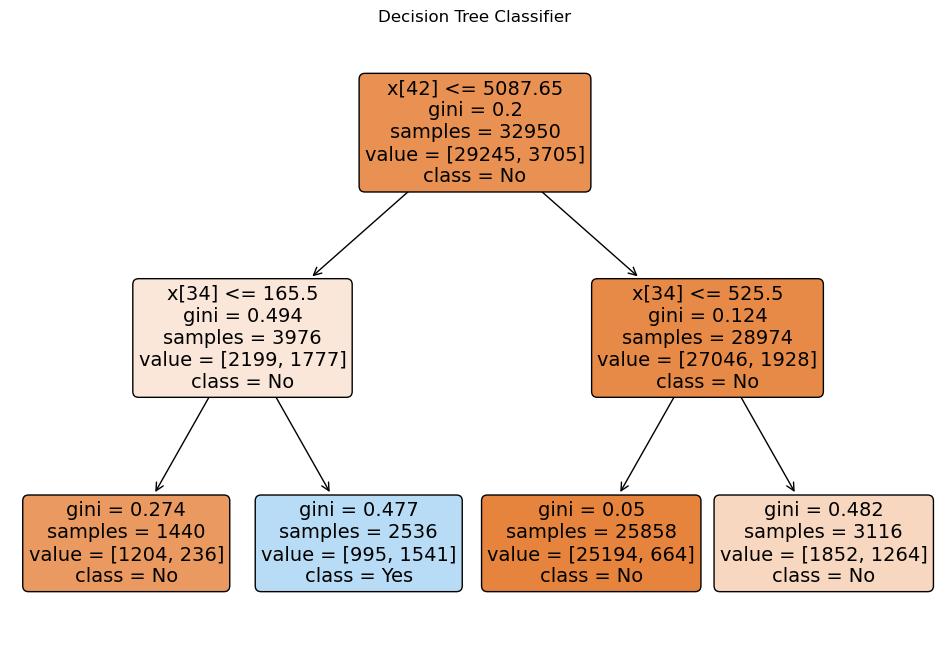

In [457]:
dt_pipeG = Pipeline([
     ('transformer', bank_transformer),
     ('dt', DecisionTreeClassifier(max_depth=2, min_impurity_decrease=0.01, min_samples_split=0.1))
 ])

# Fit the pipeline to your training data
dt_pipeG.fit(X_train, y_train)

# Access the decision tree classifier from the pipeline
tree_classifier = dt_pipeG.named_steps['dt']

# Plot the decision tree
plt.figure(figsize=(12, 8))
plot_tree(tree_classifier, filled=True, rounded=True, class_names=['No', 'Yes'])
plt.title('Decision Tree Classifier')
plt.show()

Using the Recall metric KNN performs significan better than the Decision Tree. KKN optimun neighborh for recall is 19.

The next step is repeat the analysis removing the features that do not have an impact on Target.

In [462]:
# New Transformation only including key variables according the individual chart analysis
bank_transformer2 = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['age']), 
        ('cat', OneHotEncoder(drop='if_binary', sparse=False, handle_unknown='ignore'), ['job', 'education', 'default']),
   ],
    remainder='passthrough')
# defining new dataframe
df2 = df1[['age', 'job', 'education', 'default', 'duration', 'current_contacts', 'days_after_prevcamp', 'previous_contact', 'employment_var_rate', 'consumer_price_I',
 'consumer_confidence_I', 'Num_employees', 'y']]

In [464]:
# define new Y and Y based on the new df
X2 = df2.drop(['y'], axis = 1)
Y2 = df2['y'].map({'no': 0, 'yes': 1})
df2

,age,job,education,default,duration,current_contacts,days_after_prevcamp,previous_contact,employment_var_rate,consumer_price_I,consumer_confidence_I,Num_employees,y
0,56,housemaid,basic.4y,no,261,1,999,0,1.1,93.994,-36.4,5191.0,no
1,57,services,high.school,unknown,149,1,999,0,1.1,93.994,-36.4,5191.0,no
2,37,services,high.school,no,226,1,999,0,1.1,93.994,-36.4,5191.0,no
3,40,admin.,basic.6y,no,151,1,999,0,1.1,93.994,-36.4,5191.0,no
4,56,services,high.school,no,307,1,999,0,1.1,93.994,-36.4,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,professional.course,no,334,1,999,0,-1.1,94.767,-50.8,4963.6,yes
41184,46,blue-collar,professional.course,no,383,1,999,0,-1.1,94.767,-50.8,4963.6,no
41185,56,retired,university.degree,no,189,2,999,0,-1.1,94.767,-50.8,4963.6,no
41186,44,technician,professional.course,no,442,1,999,0,-1.1,94.767,-50.8,4963.6,yes


In [465]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, Y2, test_size=0.2, random_state = 42)

knn_pipe2 = Pipeline([('transformer',bank_transformer2),                
                    ('knn',  KNeighborsClassifier())])
dt_pipe2 =  Pipeline([('transformer',bank_transformer2),                
                    ('dt',  DecisionTreeClassifier())])

# KNN GridSearch

In [476]:
# Define the parameter grid for accuracy optimization
params_accuracy = {'knn__n_neighbors': list(range(1, 50, 2))}

# Define the parameter grid for recall optimization
params_recall = {'knn__n_neighbors': list(range(1, 50, 2))}

# Grid search for accuracy optimization
grid_accuracy = GridSearchCV(knn_pipe2, param_grid=params_accuracy).fit(X_train2, y_train2)
best_params_accuracy = grid_accuracy.best_params_

# Grid search for recall optimization
grid_recall = GridSearchCV(knn_pipe2, param_grid=params_recall, scoring='recall').fit(X_train2, y_train2)
best_params_recall = grid_recall.best_params_

# Fit models with the best parameters
best_knn_accuracy = grid_accuracy.best_estimator_
best_knn_recall = grid_recall.best_estimator_

# Evaluate models on the test data
y_test_accuracy = best_knn_accuracy.predict(X_test2)
y_test_recall = best_knn_recall.predict(X_test2)

accuracy = accuracy_score(y_test2, y_test_accuracy)
recall = recall_score(y_test2, y_test_recall)

print(f'Best parameters for accuracy: {best_params_accuracy}')
print(f'Best parameters for recall: {best_params_recall}')
print(f'Accuracy on test data: {accuracy:.2f}')
print(f'Recall on test data: {recall:.2f}')

Best parameters for accuracy: {'knn__n_neighbors': 41}
Best parameters for recall: {'knn__n_neighbors': 19}
Accuracy on test data: 0.91
Recall on test data: 0.50


#Decision Tree GridSearch

In [477]:
# Define the parameter grid for accuracy optimization
params_accuracy = {
    'dt__min_impurity_decrease': [0.01, 0.02, 0.03, 0.05],
    'dt__max_depth': [2, 5, 10],
    'dt__min_samples_split': [0.1, 0.2, 0.05]
}

# Define the parameter grid for recall optimization
params_recall = {
    'dt__min_impurity_decrease': [0.01, 0.02, 0.03, 0.05],
    'dt__max_depth': [2, 5, 10],
    'dt__min_samples_split': [0.1, 0.2, 0.05]
}

# Grid search for accuracy optimization
grid_accuracy = GridSearchCV(dt_pipe2, param_grid=params_accuracy).fit(X_train2, y_train2)
best_params_accuracy = grid_accuracy.best_params_

# Grid search for recall optimization
grid_recall = GridSearchCV(dt_pipe2, param_grid=params_recall, scoring='recall').fit(X_train2, y_train2)
best_params_recall = grid_recall.best_params_

# Fit models with the best parameters
best_dt_accuracy = grid_accuracy.best_estimator_
best_dt_recall = grid_recall.best_estimator_

# Evaluate models on the test data
y_test_accuracy = best_dt_accuracy.predict(X_test2)
y_test_recall = best_dt_recall.predict(X_test2)

accuracy = accuracy_score(y_test2, y_test_accuracy)
recall = recall_score(y_test2, y_test_recall)

print(f'Best parameters for accuracy: {best_params_accuracy}')
print(f'Best parameters for recall: {best_params_recall}')
print(f'Accuracy on test data: {accuracy:.2f}')
print(f'Recall on test data: {recall:.2f}')

Best parameters for accuracy: {'dt__max_depth': 2, 'dt__min_impurity_decrease': 0.01, 'dt__min_samples_split': 0.1}
Best parameters for recall: {'dt__max_depth': 2, 'dt__min_impurity_decrease': 0.01, 'dt__min_samples_split': 0.1}
Accuracy on test data: 0.90
Recall on test data: 0.40


Removing the identified feature led to same results, using the Recall metric KNN performs significan better than the Decision Tree. KKN optimun neighborh for recall is 19.


Next Steps

Model Selection: Based on the evaluation of different classifiers, select the best-performing model. This could be the model that achieves the highest accuracy or the one that optimizes a specific metric relevant to the business problem (e.g., recall if correctly identifying positive cases is crucial).

Feature Importance: Understand which features (attributes) have the most significant impact on the model's predictions. 

Business Impact Assessment: Continuously assess the business impact of using the model. Measure how it contributes to achieving business goals, such as increasing term deposit subscriptions or optimizing marketing campaigns.

Documentation: Document the model, its architecture, and its deployment process thoroughly. This documentation is essential for maintaining and updating the model in the future.

